In [1]:

# Bibliotheken importieren
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam



/Users/jarmo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Bibliotheken erklärung 

numpy: Für numerische Berechnungen und effiziente Arbeit mit Arrays (z.B. Bilder als Matrizen).
tensorflow: Framework für maschinelles Lernen und Deep Learning, das neuronale Netze trainiert und ausführt.
tensorflow.keras.datasets: Enthält vorgefertigte Datensätze wie CIFAR-10 zum einfachen Laden.
tensorflow.keras.utils.to_categorical: Wandelt Labels in One-Hot-Format um (wichtig für Klassifikation).
tensorflow.keras.applications.ResNet50: Vorgefertigtes, tiefes neuronales Netz (ResNet50) für Bildklassifikation.
tensorflow.keras.models.Model: Erstellen und kombinieren von Modellen (z.B. Basismodell + eigene Schichten).
tensorflow.keras.layers: Enthält Bausteine für neuronale Netze (z.B. Dense, GlobalAveragePooling2D, Input).
tensorflow.keras.optimizers.Adam: Optimierungsalgorithmus für das Training des Netzes.

In [2]:
pip install tensorflow 

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

In [4]:
train_images.shape 

(50000, 32, 32, 3)

In [5]:
n = 10000

train_images = train_images[:n]
train_labels = train_labels[:n]

In [6]:
train_labels 

array([[6],
       [9],
       [9],
       ...,
       [1],
       [1],
       [5]], dtype=uint8)

In [7]:
train_images.shape

(10000, 32, 32, 3)

In [8]:
train_labels.shape

(10000, 1)

In [9]:
# Labels von (10000, 1) zu (10000,) umformen
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()


In [10]:
train_labels.shape

(10000,)

In [11]:
#Schauen wie ausgeglichen die die klassen in de ersten 10k daten verteilt sind. 
pd.Series(train_labels).value_counts()

2    1032
6    1030
8    1025
3    1016
0    1005
7    1001
4     999
9     981
1     974
5     937
Name: count, dtype: int64

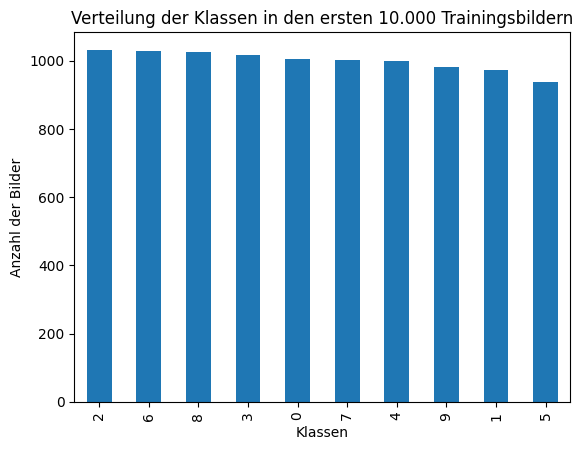

In [12]:
#verteilung plotten 

import matplotlib.pyplot as plt
pd.Series(train_labels).value_counts().plot(kind='bar')
plt.xlabel('Klassen')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Klassen in den ersten 10.000 Trainingsbildern')
plt.show()


In [13]:
train_images.shape

(10000, 32, 32, 3)

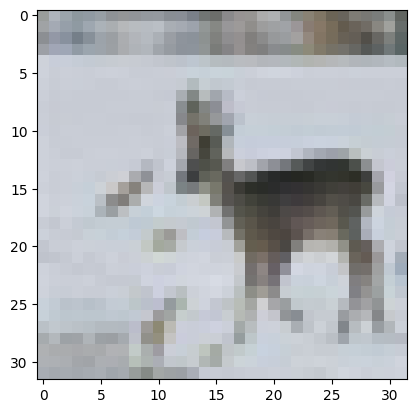

In [14]:
i = 20 
img = train_images[i]

plt.imshow(img)

In [15]:
# Schritt 2: Bildvorverarbeitung und One-Hot-Encoding der Labels
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

print('Train images shape:', train_images.shape)
print('Test images shape:', test_images.shape)
print('Train labels shape:', train_labels.shape)

Train images shape: (10000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Train labels shape: (10000, 10)


In [16]:
 #Einzigartige Klassen-Labels im Datensatz anzeigen
print("Eindeutige Klassen-Labels im Datensatz:", np.unique(train_labels))

Eindeutige Klassen-Labels im Datensatz: [0. 1.]


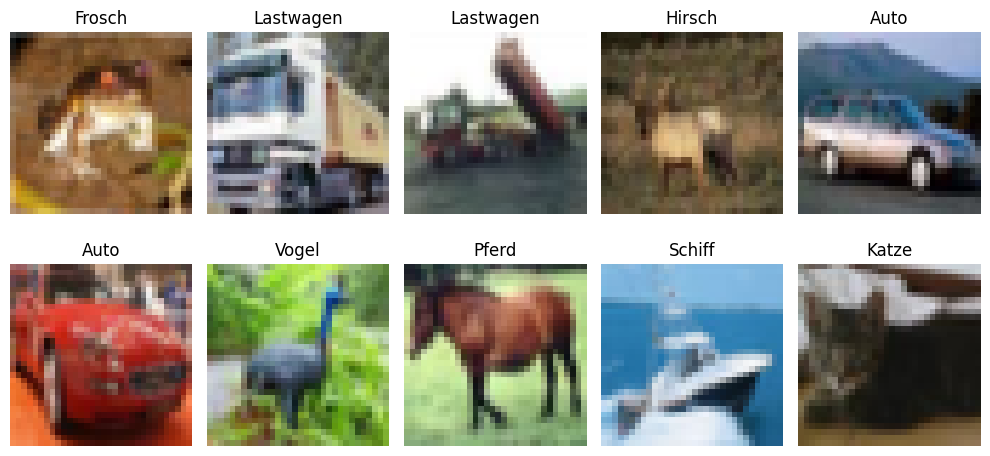

In [17]:
# Beispielbilder aus dem CIFAR-10 Datensatz anzeigen
import matplotlib.pyplot as plt

class_names = ['Flugzeug', 'Auto', 'Vogel', 'Katze', 'Hirsch', 'Hund', 'Frosch', 'Pferd', 'Schiff', 'Lastwagen']

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[np.argmax(train_labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Schritt 3: ResNet50-Basismodell initialisieren und einfrieren
input_tensor = Input(shape=(32, 32, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_tensor)

# Basismodell einfrieren
for layer in base_model.layers:
    layer.trainable = False

print('ResNet50 Basismodell initialisiert und eingefroren.')

ResNet50 Basismodell initialisiert und eingefroren.


**Warum das Basismodell einfrieren?**
Das Einfrieren der ResNet50-Schichten sorgt dafür, dass die vortrainierten Bildmerkmale erhalten bleiben. Zuerst werden nur die neuen, eigenen Schichten trainiert, damit das Modell die allgemeinen Features nicht verlernt. Erst später wird das gesamte Modell feinjustiert.

In [19]:
# Schritt 4: Kopf des Modells bauen und Modell zusammenfügen
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [20]:
# Schritt 5: Modell kompilieren
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Modell kompiliert und bereit zum Training.')

Modell kompiliert und bereit zum Training.


In [21]:
# Schritt 6: Nur den Kopf des Modells für 10 Epochen trainieren
history_head = model.fit(train_images, train_labels,
                        epochs=10,
                        batch_size=64,
                        validation_data=(test_images, test_labels))

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.1354 - loss: 2.3115 - val_accuracy: 0.2125 - val_loss: 2.1317
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.2190 - loss: 2.1181 - val_accuracy: 0.2349 - val_loss: 2.0661
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.2487 - loss: 2.0456 - val_accuracy: 0.2814 - val_loss: 1.9734
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.2700 - loss: 1.9920 - val_accuracy: 0.2808 - val_loss: 1.9409
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.2908 - loss: 1.9511 - val_accuracy: 0.3057 - val_loss: 1.9127
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.3073 - loss: 1.8991 - val_accuracy: 0.2891 - val_loss: 1.9465
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.3281 - loss: 1.8670 - val_accuracy: 0.3212 - val_loss: 1.8730
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.3249 - loss: 1

In [22]:
# Schritt 7: Basismodell freigeben und gesamtes Modell für 10 Epochen trainieren
for layer in base_model.layers:
    layer.trainable = True

history_finetune = model.fit(train_images, train_labels,
                             epochs=10,
                             batch_size=64,
                             validation_data=(test_images, test_labels))

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.3357 - loss: 1.8269 - val_accuracy: 0.3413 - val_loss: 1.8087
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.3484 - loss: 1.8069 - val_accuracy: 0.3397 - val_loss: 1.8020
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.3426 - loss: 1.8069 - val_accuracy: 0.3533 - val_loss: 1.7828
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.3487 - loss: 1.7873 - val_accuracy: 0.3403 - val_loss: 1.8312
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.3537 - loss: 1.7820 - val_accuracy: 0.3252 - val_loss: 1.8654
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.3537 - loss: 1.7793 - val_accuracy: 0.3467 - val_loss: 1.8268
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.3599 - loss: 1.7627 - val_accuracy: 0.3351 - val_loss: 1.8549
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.3595 - loss: 1

In [23]:
# Schritt 8: Modell auf Testdaten bewerten
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Testgenauigkeit: {test_acc:.4f}')
print(f'Testverlust: {test_loss:.4f}')

313/313 - 10s - 33ms/step - accuracy: 0.3721 - loss: 1.7504
Testgenauigkeit: 0.3721
Testverlust: 1.7504


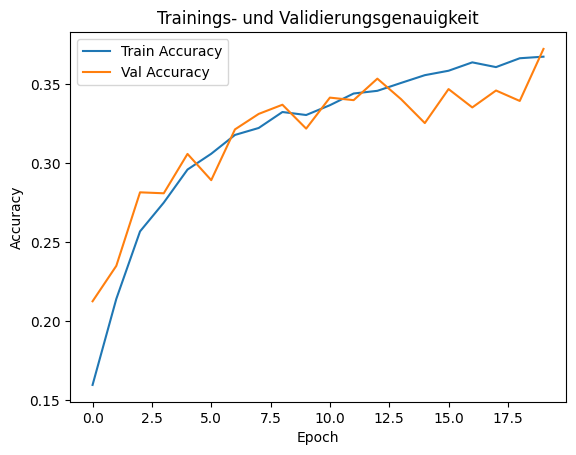

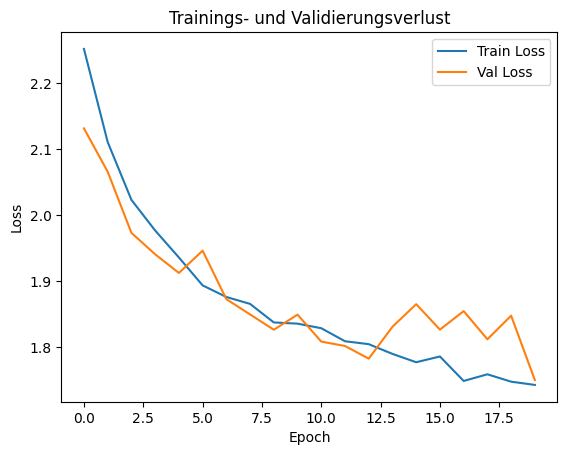

In [24]:
import matplotlib.pyplot as plt

# Trainings- und Validierungsgenauigkeit
plt.plot(history_head.history['accuracy'] + history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_head.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Trainings- und Validierungsgenauigkeit')
plt.show()

# Trainings- und Validierungsverlust
plt.plot(history_head.history['loss'] + history_finetune.history['loss'], label='Train Loss')
plt.plot(history_head.history['val_loss'] + history_finetune.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Trainings- und Validierungsverlust')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


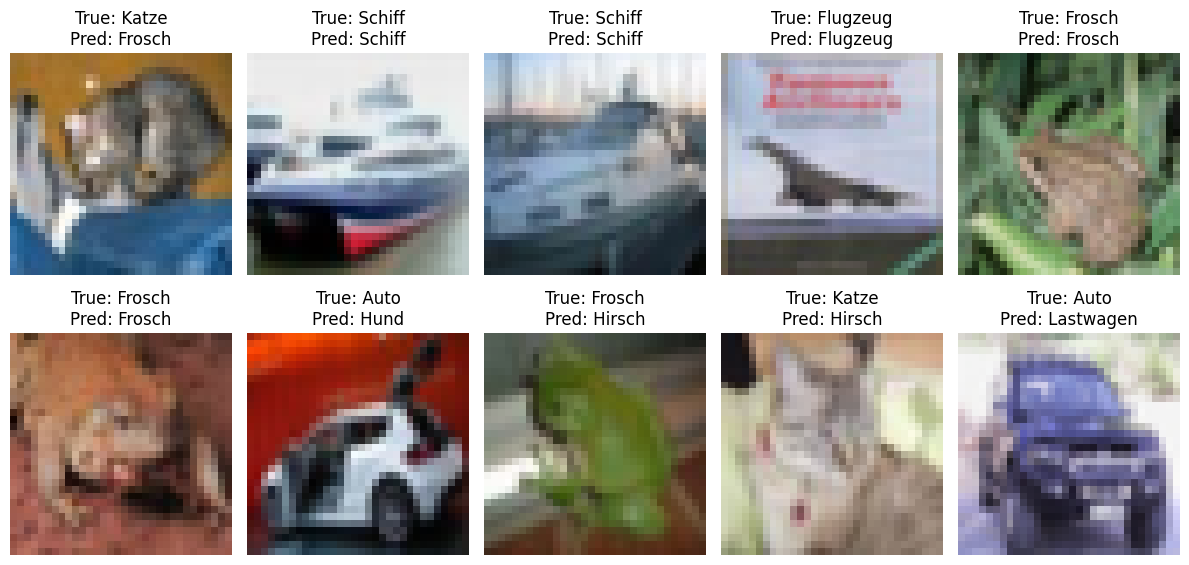

In [25]:
import numpy as np

preds = model.predict(test_images)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(test_labels, axis=1)

class_names = ['Flugzeug', 'Auto', 'Vogel', 'Katze', 'Hirsch', 'Hund', 'Frosch', 'Pferd', 'Schiff', 'Lastwagen']

plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()